In [1]:
import glob
import os
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
print("...beginning loading data...")
curr_file_list = glob.glob(os.path.join('../GET_DATA/preprocessing/txt/ASW/', '*txt'))

DataList=[]
c=0
for filename in sorted(curr_file_list):
    with open(filename) as file:
        data = pd.read_csv(file, sep='\t', header=None, names=['dateGMT', 'timeGMT', 'unixTime', 'lat', 'lon'])
        data["timeGMT"] = data["timeGMT"].str.replace(pat=r'\|000|\|00', repl=r'', regex=True)
        data["timeGMT"] = data["timeGMT"].str.replace(pat=r':', repl=r'', regex=True)
        data["dateGMT"] = data["dateGMT"].str.replace(pat=r'|', repl='', regex=True)
        data["unixTime"] = data["unixTime"].str.replace(pat=r'\|000|\|00', repl=r'', regex=True)
#         data["dateTimeGMT"] = pd.to_datetime(data["dateGMT"]+data["timeGMT"], format='%Y%m%d%H%M%S')
        data.drop(['dateGMT', 'timeGMT','unixTime'], axis=1, inplace=True)
        DataList.append([c,data])
        c+=1

...beginning loading data...


# data 분리

In [2]:
def split(data):
    l=int(len(data)*0.6)
    
    train=data.loc[:l]
    test=data.loc[l:]
    
    return [train,test]

In [3]:
t=int(input('dataset: '))
if DataList[t][1].shape[0]<100:
    print('data is too small')
else:
    train_data,test_data=split(DataList[t][1])

dataset: 9


# 그려보기

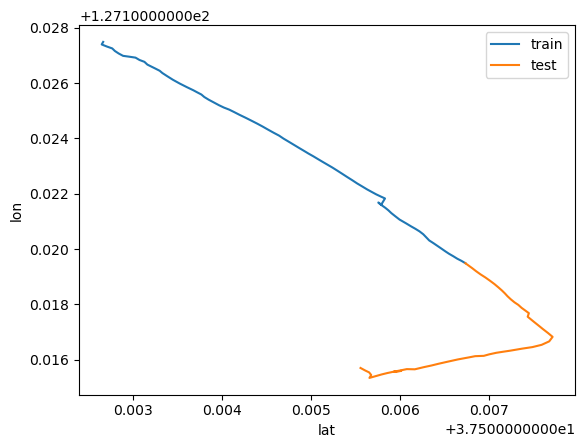

In [4]:
plt.plot(train_data['lat'],train_data['lon'])
plt.plot(test_data['lat'],test_data['lon'])
plt.legend(['train', 'test'])
plt.xlabel('lat')
plt.ylabel('lon')
plt.show()

# 변수 scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train_data)
test_sc = sc.transform(test_data)

# Pandas Dataframe으로 변환

In [6]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled_lat','Scaled_lon'], index=train_data.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled_lat','Scaled_lon'], index=test_data.index)
train_sc_df.head()

,Scaled_lat,Scaled_lon
0,0.004078,1.000000
1,0.000000,0.988544
2,0.014274,0.979171
3,0.028956,0.970631
4,0.036297,0.958967


# pandas shift를 통해 Window 만들기

In [7]:
w=int(input('원하는 window를 입력하시오 : '))
for s in range(1, w):
    train_sc_df['shift_{}_lat'.format(s)],train_sc_df['shift_{}_lon'.format(s)] = train_sc_df['Scaled_lat'].shift(s),train_sc_df['Scaled_lon'].shift(s)
    test_sc_df['shift_{}_lat'.format(s)],test_sc_df['shift_{}_lon'.format(s)] = test_sc_df['Scaled_lat'].shift(s),test_sc_df['Scaled_lon'].shift(s)

train_sc_df.head(w)


원하는 window를 입력하시오 : 6


,Scaled_lat,Scaled_lon,shift_1_lat,shift_1_lon,shift_2_lat,shift_2_lon,shift_3_lat,shift_3_lon,shift_4_lat,shift_4_lon,shift_5_lat,shift_5_lon
0,0.004078,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.988544,0.004078,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014274,0.979171,0.000000,0.988544,0.004078,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,0.028956,0.970631,0.014274,0.979171,0.000000,0.988544,0.004078,1.000000,NaN,NaN,NaN,NaN
4,0.036297,0.958967,0.028956,0.970631,0.014274,0.979171,0.000000,0.988544,0.004078,1.000000,NaN,NaN
5,0.046493,0.947928,0.036297,0.958967,0.028956,0.970631,0.014274,0.979171,0.000000,0.988544,0.004078,1.0


# 트레이닝셋과 테스트셋 만들기

In [8]:
k=w-1
X_train = train_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
y_train = train_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]

X_test = test_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
y_test = test_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]

In [9]:
X_train

,Scaled_lat,Scaled_lon,shift_1_lat,shift_1_lon,shift_2_lat,shift_2_lon,shift_3_lat,shift_3_lon,shift_4_lat,shift_4_lon
5,0.046493,0.947928,0.036297,0.958967,0.028956,0.970631,0.014274,0.979171,0.000000,0.988544
6,0.058728,0.937096,0.046493,0.947928,0.036297,0.958967,0.028956,0.970631,0.014274,0.979171
7,0.076264,0.933139,0.058728,0.937096,0.046493,0.947928,0.036297,0.958967,0.028956,0.970631
8,0.092985,0.928973,0.076264,0.933139,0.058728,0.937096,0.046493,0.947928,0.036297,0.958967
9,0.103997,0.918350,0.092985,0.928973,0.076264,0.933139,0.058728,0.937096,0.046493,0.947928
...,...,...,...,...,...,...,...,...,...,...
79,0.954731,0.042908,0.944943,0.053531,0.934747,0.065195,0.922512,0.078942,0.911909,0.090814
80,0.966966,0.031243,0.954731,0.042908,0.944943,0.053531,0.934747,0.065195,0.922512,0.078942
81,0.977569,0.020412,0.966966,0.031243,0.954731,0.042908,0.944943,0.053531,0.934747,0.065195
82,0.989396,0.010414,0.977569,0.020412,0.966966,0.031243,0.954731,0.042908,0.944943,0.053531


# 다시 ndarray로 변환하기

In [10]:
X_train=X_train.values
y_train=y_train.values
X_test=X_test.values
y_test=y_test.values
X_train.shape,y_train.shape

((79, 10), (79, 2))

# 최종 트레이닝셋과 테스트셋의 X 만들기

In [11]:
X_train_t = X_train.reshape(X_train.shape[0], k, 2)
X_test_t = X_test.reshape(X_test.shape[0],k, 2)

## LSTM 모델 만들기

In [12]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()
model = Sequential() # Sequeatial Model
model.add(LSTM(200, input_shape=(k, 2))) # (timestep, feature)
model.add(Dense(100))
model.add(Dense(2)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               162400    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 182,702
Trainable params: 182,702
Non-trainable params: 0
_________________________________________________________________


In [13]:
p=20 #int(input('patience : '))
early_stop = EarlyStopping(monitor='loss',mode='auto',patience=p, verbose=1)

result=model.fit(X_train_t, y_train, epochs=500,
          batch_size=32, verbose=1, callbacks=[early_stop])


Epoch 1/500
3/3 [==============================] - 26s 6ms/step - loss: 0.2729 - accuracy: 0.9488
Epoch 2/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0606 - accuracy: 0.9820
Epoch 3/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 1.0000
Epoch 4/500
3/3 [==============================] - 0s 8ms/step - loss: 0.0286 - accuracy: 0.9937
Epoch 5/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0058 - accuracy: 0.9937
Epoch 6/500
3/3 [==============================] - 0s 7ms/step - loss: 0.0097 - accuracy: 0.9937
Epoch 7/500
3/3 [==============================] - 0s 6ms/step - loss: 0.0131 - accuracy: 0.9820
Epoch 8/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 9/500
3/3 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.9937
Epoch 10/500
3/3 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 11/500
3/3 [==========

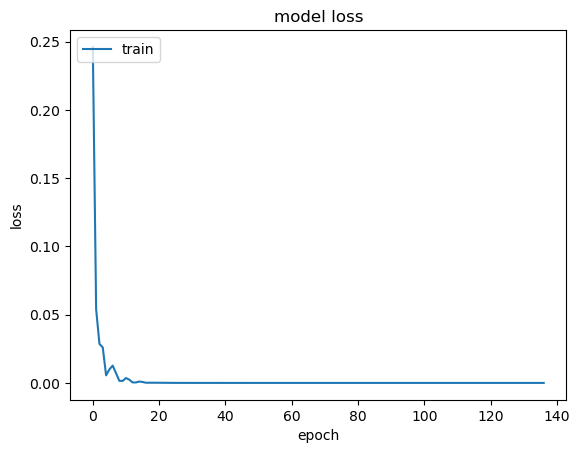

In [14]:
# summarize history for loss
plt.plot(result.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
y_pred = model.predict(X_test_t)
y_pred = sc.inverse_transform(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['prediction_lat','prediction_lon'])
Y_test=sc.inverse_transform(y_test)

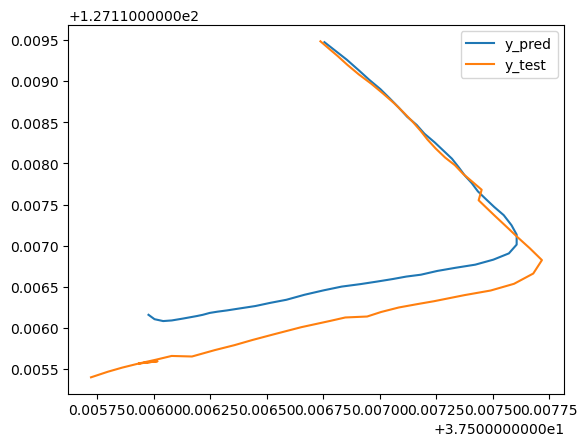

In [16]:
plt.plot(y_pred_df['prediction_lat'],y_pred_df['prediction_lon'])
plt.plot(Y_test[:,0],Y_test[:,1])
plt.legend(['y_pred', 'y_test'])
plt.show()

In [17]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [18]:
distance=haversine(Y_test[-1][0],Y_test[-1][1],y_pred[-1][0],y_pred[-1][1])

## 지도에 표시

In [19]:
import pandas as pd
import folium
 
ASW_map = folium.Map(location=[Y_test[:,0].mean(),Y_test[:,1].mean()], zoom_start=13)
df_cities = pd.DataFrame({'위도':Y_test[:,0], '경도':Y_test[:,1]},index=[i for i in range(len(Y_test))])
d=[]
for i in range(len(df_cities)):
    folium.Circle([df_cities.iloc[i][0], df_cities.iloc[i][1]],radius=1,color='black').add_to(ASW_map)#, popup=df_cities.index[i]
    folium.Circle([y_pred[i][0],y_pred[i][1]],radius=1,color='red').add_to(ASW_map)#,popup='predicted location',icon=folium.Icon(color='red',icon_color='blue'
    d.append(haversine(df_cities.iloc[i][0],df_cities.iloc[i][1],y_pred[i][0],y_pred[i][1]))

    
'''    
folium.Marker(
    [df_cities.iloc[-1][0], df_cities.iloc[-1][1]],popup='last location',icon=folium.Icon(color='red',icon_color='blue')
).add_to(ASW_map)    '''


"    \nfolium.Marker(\n    [df_cities.iloc[-1][0], df_cities.iloc[-1][1]],popup='last location',icon=folium.Icon(color='red',icon_color='blue')\n).add_to(ASW_map)    "

In [20]:
def avd(d):
    return np.mean(d)

avd(d)

0.025919058917931

In [21]:
result_db = pd.DataFrame(columns = ['data','real', 'predict', 'distance','average_distance''window_size','patience']) 
data_to_insert={'data':t,'real': Y_test[-1], 'predict': y_pred[-1], 'distance': distance,'average_distance':avd(d),'patience': p,'window_size': k+1}
result_db = result_db.append(data_to_insert, ignore_index=True)
result_db

,data,real,predict,distance,average_distancewindow_size,patience,average_distance,window_size
0,9,"[37.505723333333, 127.115396666667]","[37.505978, 127.11616]",0.086308,NaN,20,0.025919,6.0


In [22]:
import os

if os.path.isfile('result.txt'):
    with open("result.txt", "a") as file:
        result_db.to_csv('result.txt',sep = '\t', index = False,mode='a')
else:
    result_db.to_csv('result.txt',sep = '\t', index = False,mode='w')

In [23]:
ASW_map

In [24]:
ASW_map.save('ASW{}.html'.format(t))